<a href="https://colab.research.google.com/github/mimijanssen/Allen-Visual-Behavior-Fam-Analysis/blob/main/2023_07_18_load_Allen_Visual_Behavior_from_SDK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
This notebook shows how to access and interact with 2-photon calcium imaging data collected as part of the Allen Institute's Visual Behavior 2P project.

You can learn more about this dataset here: <br>[brain-map.org/explore/circuits/visual-behavior-2p](brain-map.org/explore/circuits/visual-behavior-2p) <br>[allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html](allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html)

Specifically, this notebook will show how to load neural data for all imaging planes in one 2-photon imaging session into a single 'tidy' dataframe, make  simple event-triggered plots, and do some basic analysis using scikit-learn.

This is designed to demonstrate a simple method for interacting with the Visual Behavior 2P data. Many aspects of the dataset are not explored here.

# Set up environment and import packages

We have built a package called `brain_observatory_utilities` which contains some useful convenience functions. The `allenSDK` is a dependency of this package and will be automatically installed when you install `brain_observatory_utilities` per the instrutions below.

We will first install `brain_observatory_utilities` into our colab environment by running the commands below. When this cell is complete, click on the `RESTART RUNTIME` button that appears at the end of the output. Note that running this cell will produce a long list of outputs and some error messages. Clicking `RESTART RUNTIME` at the end will resolve these issues.

You can minimize the cell after you are done to hide the output.

In [4]:
# @title Install packages
!pip install pip --upgrade --quiet
#!pip install brain_observatory_utilities --upgrade --quiet
!pip install git+https://github.com/slinderman/AllenSDK@master
!pip install brain_observatory_utilities
!pip install pandas --quiet
!pip install seaborn --quiet

  Cloning https://github.com/slinderman/AllenSDK (to revision master) to /tmp/pip-req-build-ww4mqvme
  Running command git clone --filter=blob:none --quiet https://github.com/slinderman/AllenSDK /tmp/pip-req-build-ww4mqvme
  Resolved https://github.com/slinderman/AllenSDK to commit 4a507fec0edd06e0909b4fbc69089e4ac12b8c42
  Preparing metadata (setup.py) ... done
  Using cached psycopg2_binary-2.9.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Obtaining dependency information for hdmf from https://files.pythonhosted.org/packages/57/d5/1783a43f6393da26d172071a1a8c0a3870dd69be5f2d3d42ad67a3d0497c/hdmf-3.7.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.0 MB/s eta 0:00:00
  Using cached simplejson-3.19.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (137 kB)
  Obtaining dependency information for scikit-build from https://files.pythonhosted.org/packages/fa/af/b3ef8fe0bb96bf

  Using cached brain_observatory_utilities-0.2.1.tar.gz (40 kB)
  Preparing metadata (setup.py) ... done
  Using cached flake8-6.0.0-py2.py3-none-any.whl (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 7.7 MB/s eta 0:00:00
  Created wheel for brain_observatory_utilities: filename=brain_observatory_utilities-0.2.1-py3-none-any.whl size=45927 sha256=c066fba6612a5e1ca2187f65891d936f1e8a744e7a1fef9e3844fc22caf3a009
  Stored in directory: /root/.cache/pip/wheels/32/bb/d9/8ad71b3ac142ee1b494504dc2c8b28e735fae0fa340a7b9351
Successfully built brain_observatory_utilities


#### Next we will import packages we need later in the notebook

In [5]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

  Using cached mindscope_utilities-0.1.9-py3-none-any.whl (19 kB)


In [6]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as ophys_formatting
import brain_observatory_utilities.utilities.general_utilities as utilities

#import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

In [7]:
def make_event_triggered_plot(df, x, y, event_query, ax, t_before=3, t_after=3):
    etr = utilities.event_triggered_response(
      data=df,
      t='timestamps',
      y=y,
      event_times=stimulus_table.query(event_query)['start_time'],
      t_before=t_before,
      t_after=t_before,
      output_sampling_rate=50,
      )
    sns.lineplot(
      data=etr,
      x=x,
      y=y,
      n_boot=500,
      ax=ax
      )

# Load the session and experiment summary tables

The AllenSDK provides functionality for downloading tables that describe all sessions and experiments (individual imaging planes) in the Visual Behavior 2P dataset. We first download the data cache:

In [8]:
data_storage_directory = "/temp"  # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv: 100%|██████████| 227k/227k [00:00<00:00, 1.22MMB/s] 
behavior_session_table.csv: 100%|██████████| 1.21M/1.21M [00:00<00:00, 6.53MMB/s]
ophys_experiment_table.csv: 100%|██████████| 610k/610k [00:00<00:00, 3.63MMB/s] 
ophys_cells_table.csv: 100%|██████████| 4.29M/4.29M [00:00<00:00, 11.7MMB/s]


- `Ophys_session_table` contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple ophys experiment ids. Each ophys session id will also have a unique behavior session id.
- `Behavior_session_table` contains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have ophys session ids were training sessions.
- `Ophys_experiment_table` contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique experiment ids. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the `ophys_container_id` column that can be found in both `ophys_session_table` and `ophys_experiment_table`.

Then we can access the session and experiment tables directly.

Note that a 'session' is a single behavioral session. Sessions that are performed on the mesoscope will have multiple (up to 8) 'experiments' associated with them, where an experiment is a distinct imaging plane.

In [9]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

We can then view the contents of the session table. Note that this contains a lot of useful metadata about each session. One of the columns, `ophys_experiment_id` provides a list of the experiments (aka imaging planes) that are associated with each session.

In [10]:
session_table.head()

equipment_name  \
ophys_session_id                  
951410079                MESO.1   
952430817                MESO.1   
954954402                MESO.1   
955775716                MESO.1   
957020350                MESO.1   

                                                  full_genotype mouse_id  \
ophys_session_id                                                           
951410079         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
952430817         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
954954402         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
955775716         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
957020350         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   

                               reporter_line     driver_line sex  age_in_days  \
ophys_session_id                                                                
951410079         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        206.0   
952430817         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        209.0   
954954402         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        210.0   
955775716         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        212.0   
957020350         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        213.0   

                      cre_line indicator  session_number  \
ophys_session_id                                           
951410079         Sst-IRES-Cre   GCaMP6f             1.0   
952430817         Sst-IRES-Cre   GCaMP6f             2.0   
954954402         Sst-IRES-Cre   GCaMP6f             3.0   
955775716         Sst-IRES-Cre   GCaMP6f             3.0   
957020350         Sst-IRES-Cre   GCaMP6f             4.0   

                  prior_exposures_to_session_type  \
ophys_session_id                                    
951410079                                     0.0   
952430817                                     0.0   
954954402                                     0.0   
955775716                                     1.0   
957020350                                     0.0   

                  prior_exposures_to_image_set  prior_exposures_to_omissions  \
ophys_session_id                                                               
951410079                                 65.0                           0.0   
952430817                                 66.0                           1.0   
954954402                                 67.0                           2.0   
955775716                                 68.0                           3.0   
957020350                                  0.0                           4.0   

                  behavior_session_id  \
ophys_session_id                        
951410079                   951520319   
952430817                   952554548   
954954402                   953982960   
955775716                   956010809   
957020350                   957032492   

                                                ophys_experiment_id  \
ophys_session_id                                                      
951410079         [951980471, 951980473, 951980475, 951980479, 9...   
952430817              [953659743, 953659745, 953659749, 953659752]   
954954402         [958527464, 958527471, 958527474, 958527479, 9...   
955775716                         [956941841, 956941844, 956941846]   
957020350         [957759562, 957759564, 957759566, 957759570, 9...   

                                                 ophys_container_id  \
ophys_session_id                                                      
951410079         [1018028360, 1018028345, 1018028357, 101802834...   
952430817          [1018028357, 1018028345, 1018028339, 1018028354]   
954954402         [1018028360, 1018028342, 1018028357, 101802835...   
955775716                      [1018028342, 1018028339, 1018028345]   
957020350         [1018028354, 1018028345, 1018028360, 101802834...   

                              pr

In [11]:
session_table.info

<bound method DataFrame.info of                  equipment_name  \
ophys_session_id                  
951410079                MESO.1   
952430817                MESO.1   
954954402                MESO.1   
955775716                MESO.1   
957020350                MESO.1   
...                         ...   
946951902               CAM2P.4   
948090163               CAM2P.4   
949209988               CAM2P.4   
952434025               CAM2P.4   
954958035               CAM2P.4   

                                                  full_genotype mouse_id  \
ophys_session_id                                                           
951410079         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
952430817         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
954954402         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
955775716         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
957020350         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-t

In [12]:
### find the container id for individual cells over exps and sessions ###
experiments ={}
ophys_session_id=session_table.index
for sessions in ophys_session_id:
 ophys_container_ids = session_table.loc[sessions]['ophys_container_id']
 experiments[sessions] = ophys_container_ids
 print(ophys_container_ids)
 # added

[1018028360, 1018028345, 1018028357, 1018028342, 1018028339, 1018028354, 1018028351]
[1018028357, 1018028345, 1018028339, 1018028354]
[1018028360, 1018028342, 1018028357, 1018028351, 1018028354, 1018028339, 1018028345]
[1018028342, 1018028339, 1018028345]
[1018028354, 1018028345, 1018028360, 1018028342, 1018028357, 1018028339, 1018028351]
[1018028357, 1018028342, 1018028345, 1018028351, 1018028360]
[1018028354, 1018028345, 1018028351, 1018028357, 1018028360, 1018028339, 1018028342]
[1018028360, 1018028342, 1018028357, 1018028339, 1018028345]
[991913453]
[991913453]
[991913453]
[991913453]
[991913453]
[991913453]
[991913453]
[991913453]
[791352433]
[791352433]
[791352433]
[791352433]
[791352433]
[791352433]
[825183217]
[825183217]
[825183217]
[825183217]
[825183217]
[825183217]
[825183217]
[876693090]
[876693090]
[876693090]
[876693090]
[876693090]
[876693090]
[991913064]
[991913064]
[991913064]
[991913064]
[991913064]
[991913064]
[991913064]
[991913064]
[869781307]
[869781307]
[8697813

In [68]:
### find the sessions + exps with the same cells ###
container_id = [803589437]
ophys_sessions = {}
for session in experiments:
  if experiments[session] == container_id:
     ophys_sessions[session] = experiments[session]
print(ophys_sessions)
# added

{806203732: [803589437], 806812738: [803589437], 807393193: [803589437], 808340530: [803589437], 809393834: [803589437], 811310092: [803589437]}


In [69]:
list(ophys_sessions.keys())[0]

806203732

In [71]:
#session_table.iloc() == [1010159622]
#= cache.get_behavior_ophys_experiment(1010159622)
#	(int(1010159622))
#session_table(ophys_experiment_id)

ophys_session_id = 806203732
session_table.loc[ophys_session_id]


equipment_name                                                               CAM2P.4
full_genotype                      Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...
mouse_id                                                                      425496
reporter_line                                                     Ai93(TITL-GCaMP6f)
driver_line                                          [Slc17a7-IRES2-Cre, Camk2a-tTA]
sex                                                                                M
age_in_days                                                                    106.0
cre_line                                                           Slc17a7-IRES2-Cre
indicator                                                                    GCaMP6f
session_number                                                                   1.0
prior_exposures_to_session_type                                                  0.0
prior_exposures_to_image_set                                     

In [32]:
extracted_sess = session_table[str(list(ophys_sessions.keys())[0])]
extracted_sess

ophys_session_id = 1010159622
session_table.loc[ophys_session_id]

KeyError: ignored

In [92]:
### take the sessions that we want and label N1 and N3 ###
for ophys_i in ophys_sessions:
  session_type_N1 = 'OPHYS_4_images_B' # N1 novel
  session_type_N3 = 'OPHYS_6_images_B' # N3 animal has seen dataset when N1 was acquired and during the passive session

  extracted_sess = session_table.loc[ophys_i]

  if extracted_sess['project_code'] == 'VisualBehaviorMultiscope':
    analysis_sess = extracted_sess.loc[ophys_i]

  if extracted_sess['session_type'] == session_type_N1:
    N1 = session_table.loc[ophys_i]

  if extracted_sess['session_type'] == session_type_N3:
    N3 = session_table.loc[ophys_i]


The experiment table has one row per experiment. Note that the `ophys_session_id` column links each experiment to its associated session in the session_table.

In [ ]:
# added
# can be used later maybe
experiments2 = {}
ophys_experiment_ids2 = session_table.loc[session_table['project_code'] == 'VisualBehaviorMultiscope']['ophys_container_id']
for ophys_experiment_id in ophys_experiment_ids2:
    experiments2[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

In [ ]:
# added
# can be used later when concatenating session
ophys_experiment_ids2 = session_table.loc[session_table['ophys_container_id'] == 1018028354]
print(session_table.loc)
ophys_experiment_idsCont = ophys_experiment_ids2.loc[ophys_experiment_ids2['ophys_container_id'] == 1018028354]
ophys_experiment_idsCont

In [ ]:
# added
# can be used later when concatenating session
experiment = experiments[ophys_experiment_ids[1]]
experiment.cell_specimen_table.head()

In [78]:
N1

equipment_name                                                               CAM2P.4
full_genotype                      Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...
mouse_id                                                                      425496
reporter_line                                                     Ai93(TITL-GCaMP6f)
driver_line                                          [Slc17a7-IRES2-Cre, Camk2a-tTA]
sex                                                                                M
age_in_days                                                                    111.0
cre_line                                                           Slc17a7-IRES2-Cre
indicator                                                                    GCaMP6f
session_number                                                                   4.0
prior_exposures_to_session_type                                                  0.0
prior_exposures_to_image_set                                     

# Load one example session
We are going to select one session from this table, session 854060305. This is a session with Sst-IRES-Cre mouse, which expressed GCaMP6f in Sst+ inhibitory interneurons. There were 6 simultaneously acquired imaging planes for this session.
We can view metadata for this session as follows:

In [91]:
ophys_session_id = 952430817
session_table.loc[ophys_session_id]

equipment_name                                                               MESO.1
full_genotype                         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
mouse_id                                                                     457841
reporter_line                                            Ai148(TIT2L-GC6f-ICL-tTA2)
driver_line                                                          [Sst-IRES-Cre]
sex                                                                               F
age_in_days                                                                   209.0
cre_line                                                               Sst-IRES-Cre
indicator                                                                   GCaMP6f
session_number                                                                  2.0
prior_exposures_to_session_type                                                 0.0
prior_exposures_to_image_set                                                

# Download all associated experiments

Each session consists of one or more 'experiments', in which each experiment is a single imaging plane

Each mesoscope session has up to 8 experiments associated with the session. We will load all sessions into a dictionary with the experiment IDs as the keys

The first time that this cell is run, the associated NWB files will be downloaded to your local `data_storage_directory`. Subsequent runs of this cell will be faster since the data will already be cached locally.

In [ ]:
#ophys_session_id = 952430817
#session_table.loc[ophys_session_id]
#ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id'] #session_table.loc[ophys_session_id]['ophys_experiment_id']
#ophys_experiment_ids4
# Delete later

[953659743, 953659745, 953659749, 953659752]

In [ ]:
#experiments = {}
#ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id'] #session_table.loc[ophys_session_id]['ophys_experiment_id']
#for ophys_experiment_id in ophys_experiment_ids: # iterate through all experiment ids
#    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

behavior_ophys_experiment_953659743.nwb: 100%|██████████| 252M/252M [00:16<00:00, 15.7MMB/s]
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
behavior_ophys_experiment_953659745.nwb: 100%|██████████| 247M/247M [00:12<00:00, 19.1MMB/s]
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/

In [99]:
N1[str(ophys_experiment_id)]


NameError: ignored

In [83]:
data = pd.concat([N1,N3])

In [ ]:
#name = [ "Manjeet", "Nikhil", "Shambhavi", "Astha" ]
#roll_no = [ 4, 1, 3, 2 ]

# using zip() to map values
#mapped = zip(name, roll_no)

In [88]:
data_name = list['N1','N2']
data = pd.concat([N1,N3])
zip(data_name, data)

TypeError: ignored

In [104]:
type(N1)

pandas.core.series.Series

In [121]:
behav_data = pd.concat([N1,N3], axis=1).transpose()


In [122]:
type(behav_data)

pandas.core.frame.DataFrame

In [123]:
behav_data

equipment_name                                      full_genotype  \
808340530        CAM2P.4  Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   
809393834        CAM2P.4  Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   

          mouse_id       reporter_line                      driver_line sex  \
808340530   425496  Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   M   
809393834   425496  Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   M   

          age_in_days           cre_line indicator session_number  \
808340530       111.0  Slc17a7-IRES2-Cre   GCaMP6f            4.0   
809393834       113.0  Slc17a7-IRES2-Cre   GCaMP6f            6.0   

          prior_exposures_to_session_type prior_exposures_to_image_set  \
808340530                             0.0                          0.0   
809393834                             0.0                          2.0   

          prior_exposures_to_omissions behavior_session_id  \
808340530                          4.0           808432167   
809393834                          6.0           809427293   

          ophys_experiment_id ophys_container_id    project_code  \
808340530         [808621034]        [803589437]  VisualBehavior   
809393834         [809501118]        [803589437]  VisualBehavior   

          date_of_acquisition      session_type  
808340530 2019-01-14 20:40:17  OPHYS_4_images_B  
809393834 2019-01-16 21:42:01  OPHYS_6_images_B

In [126]:
len(behav_data)

2

In [137]:
for iter in behav_data.loc[:,['ophys_experiment_id']]: #ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over

  exp = behav_data.loc[:,['ophys_experiment_id']]
#Report_Card.loc[:,["Lectures","Grades"]]
  exp[iter]

In [139]:
type(exp)

pandas.core.frame.DataFrame

In [142]:
exp

ophys_experiment_id
808340530         [808621034]
809393834         [809501118]

In [136]:
neural_data = []
experiments = []
for iter in behav_data.loc[:,['ophys_experiment_id']]: #ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    exp = behav_data.loc[:,['ophys_experiment_id']]
    this_exp = exp[iter]
    this_experiment_neural_data = ophys_formatting.build_tidy_cell_df(this_exp)

    # add some columns with metadata for the experiment
    metadata_keys = [
      'ophys_experiment_id',
      'ophys_session_id',
      'targeted_structure',
      'imaging_depth',
      'equipment_name',
      'cre_line',
      'mouse_id',
      'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]

    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)

# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

AttributeError: ignored

In [120]:
mean_dff_by_experiment = (
    neural_data
    .groupby(['ophys_experiment_id','timestamps'])['dff']
    .mean()
    .reset_index()
)

KeyError: ignored

In [ ]:
stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations
stimulus_table.head(10)

duration  end_frame  flashes_since_change  \
stimulus_presentations_id                                              
0                           0.25023    18002.0                   0.0   
1                           0.25000        NaN                   0.0   
2                           0.25021    18092.0                   1.0   
3                           0.25019    18137.0                   2.0   
4                           0.25020    18182.0                   0.0   
5                           0.25019    18227.0                   1.0   
6                           0.25013    18272.0                   2.0   
7                           0.25020    18317.0                   3.0   
8                           0.25019    18362.0                   4.0   
9                           0.25021    18407.0                   5.0   

                           image_index image_name  is_change  omitted  \
stimulus_presentations_id                                               
0                                    0      im065      False    False   
1                                    8    omitted      False     True   
2                                    0      im065      False    False   
3                                    0      im065      False    False   
4                                    3      im061       True    False   
5                                    3      im061      False    False   
6                                    3      im061      False    False   
7                                    3      im061      False    False   
8                                    3      im061      False    False   
9                                    3      im061      False    False   

                           start_frame  start_time   end_time  
stimulus_presentations_id                                      
0                                17987   309.65357  309.90380  
1                                18031   310.38755  310.63755  
2                                18077   311.15483  311.40504  
3                                18122   311.90545  312.15564  
4                                18167   312.65605  312.90625  
5                                18212   313.40666  313.65685  
6                                18257   314.15735  314.40748  
7                                18302   314.90789  315.15809  
8                                18347   315.65850  315.90869  
9                                18392   316.40910  316.65931

In [ ]:
ophys_experiment_ids

[953659743, 953659745, 953659749, 953659752]

In [ ]:
cell_ids = neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

there are 60 unique cells
cell ids are: [1086622595 1086622778 1086624500 1086620813 1086620446 1086621290
 1086621629 1086621968 1086622408 1086621068 1086624821 1086622997
 1086623189 1086619317 1086619511 1086619787 1086620671 1086619928
 1086620900 1086622864 1086620350 1086622092 1086620268 1086620481
 1086620555 1086607768 1086610034 1086606974 1086607071 1086607143
 1086607431 1086607713 1086607903 1086607562 1086607814 1086610115
 1086608379 1086608075 1086608138 1086608195 1086610134 1086607340
 1086607998 1086607195 1086608491 1086608811 1086608630 1086608294
 1086618122 1086618511 1086618338 1086617875 1086618037 1086618253
 1086618186 1086617208 1086617474 1086619247 1086619132 1086619551]


In [ ]:
single_cell_timeseries = neural_data.query('cell_specimen_id == 1086557208')
single_cell_timeseries.head()

In [ ]:
cell_id = cell_ids[11]
etr = utilities.event_triggered_response(
    data=neural_data.query('cell_specimen_id == @cell_id'),
    t='timestamps',
    y='dff',
    event_times=stimulus_table.query('omitted')['start_time'],
    t_before=3,
    t_after=3,
    output_sampling_rate=50,
)
etr

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
single_cell_timeseries.plot(
    x = 'timestamps',
    y = 'dff',
    ax = ax
)
fig.show()

In [ ]:
### EVENT TRIGGERED PLOT OVER SESSIONS ###
#selected_experiment_table = experiment_table[(experiment_table.cre_line=='Sst-IRES-Cre')&
#(experiment_table.session_number==4) &
#(experiment_table.prior_exposures_to_image_set==0)]

# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

# iterate over every `ophys_experiment_id`
for ophys_session_id in tqdm(ophys_experiment_ids):

    make_event_triggered_plot(
        df = mean_dff_by_experiment.query('ophys_experiment_id == @ophys_experiment_id'),
        x = 'time',
        y = 'dff',
        event_query = 'omitted',
        ax=ax
    )

    # get some metadata to add to the legend
    this_exp = neural_data.query('ophys_experiment_id == @ophys_experiment_id')
    structure = this_exp['targeted_structure'].iloc[0]
    depth = this_exp['imaging_depth'].iloc[0]

    # append a string to our list of legend text
    legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))

# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1))

## View the max projection and one cell ROI for one of the experiments
We can view the `cell_specimen_table` for one experiment, which contains information about each identified cell in that experiment

In [ ]:
experiment = experiments[ophys_experiment_ids[1]]
experiment.cell_specimen_table.head()

cell_roi_id  height  mask_image_plane  max_correction_down  \
cell_specimen_id                                                               
1086619317         1080740812      19                 0                  5.0   
1086619511         1080740815      20                 0                  5.0   
1086619787         1080740822      19                 0                  5.0   
1086620671         1080740826      20                 0                  5.0   
1086619928         1080740831      19                 0                  5.0   

                  max_correction_left  max_correction_right  \
cell_specimen_id                                              
1086619317                        7.0                   4.0   
1086619511                        7.0                   4.0   
1086619787                        7.0                   4.0   
1086620671                        7.0                   4.0   
1086619928                        7.0                   4.0   

                  max_correction_up  valid_roi  width    x    y  \
cell_specimen_id                                                  
1086619317                     10.0       True     14  369  311   
1086619511                     10.0       True     19  112  264   
1086619787                     10.0       True     20  382  218   
1086620671                     10.0       True     26  150  218   
1086619928                     10.0       True     22  190  217   

                                                           roi_mask  
cell_specimen_id                                                     
1086619317        [[False, False, False, False, False, False, Fa...  
1086619511        [[False, False, False, False, False, False, Fa...  
1086619787        [[False, False, False, False, False, False, Fa...  
1086620671        [[False, False, False, False, False, False, Fa...  
1086619928        [[False, False, False, False, False, False, Fa...

We can then visualize the max projection and one of the identified ROIs

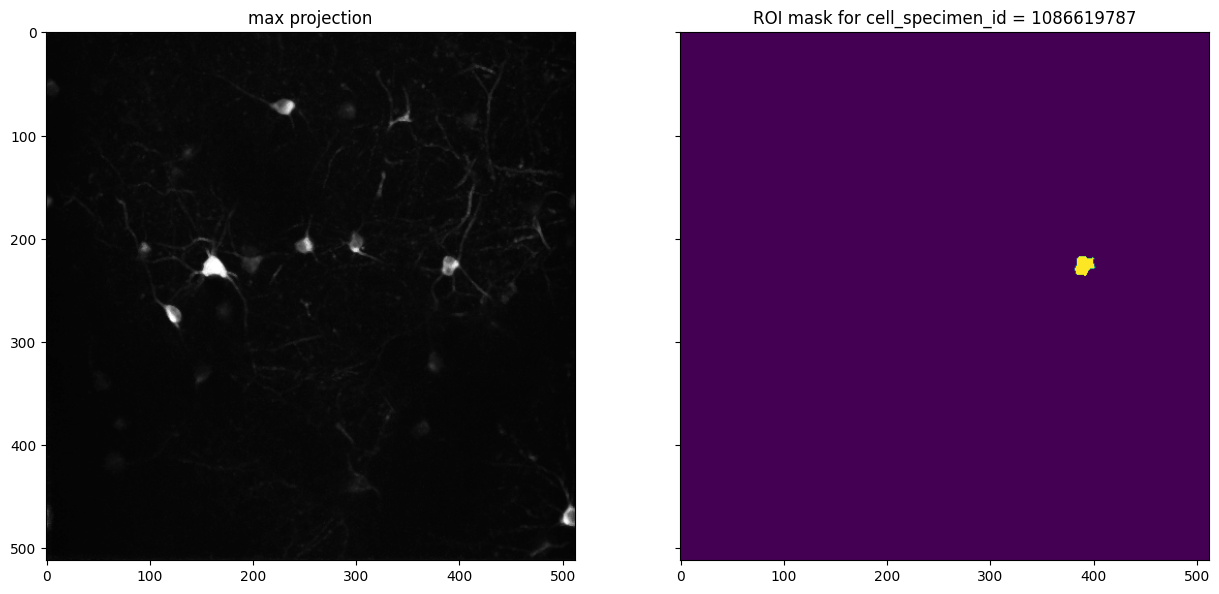

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)
ax[0].imshow(experiment.max_projection, cmap='gray')
ax[0].set_title('max projection')

cell_specimen_id = experiment.cell_specimen_table.index[2]
ax[1].imshow(experiment.cell_specimen_table.loc[cell_specimen_id]['roi_mask'])
ax[1].set_title('ROI mask for cell_specimen_id = {}'.format(cell_specimen_id))
fig.show()

  0%|          | 0/10 [00:07<?, ?it/s]


KeyboardInterrupt: ignored

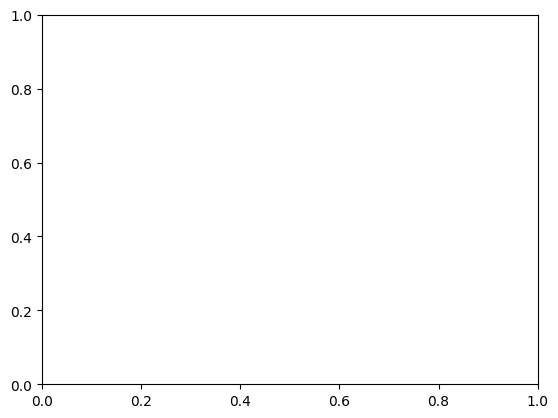

In [ ]:
np.random.seed(0)
fig, ax = plt.subplots()
for cell_id in tqdm(np.random.choice(cell_ids, size=10, replace=False)):
    make_event_triggered_plot(
      df=neural_data.query('cell_specimen_id == @cell_id'),
      x='time',
      y='dff',
      event_query='omitted',
      ax=ax
      )
fig.show()

## Load neural data into memory


The cell below will load the neural data into memory in the pandas 'tidy' format by iterating over each of the 6 experiments and using some helpful tools from the `brain_observatory_utilities` package that was imported above as `ophys`.

It will also include a subset of metadata from `ophys_experiment_table` to facilitate splitting by depth, structure (aka cortical area), cre line (aka cell class), etc.

Note that 'tidy' data means that each row represents only one observation. Observations are stacked vertically. Thus, the `timestamps` colums will repeat for every cell in the dataset.

In [ ]:
neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys_formatting.build_tidy_cell_df(this_experiment)

    # add some columns with metadata for the experiment
    metadata_keys = [
      'ophys_experiment_id',
      'ophys_session_id',
      'targeted_structure',
      'imaging_depth',
      'equipment_name',
      'cre_line',
      'mouse_id',
      'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]

    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)

# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


We can then look at some attributes of the `neural_data` dataframe we have created.

It is ~2.5 million rows long:

In [ ]:
len(neural_data)

20937282

It is so long because has one row for each timestamp for each cell.

Below are the first 5 entries. Again, note that the `tidy` format means that each row has only one observation, which represents a single GCaMP6 fluorescnce value for a single neuron.

In [ ]:
neural_data.head()

timestamps       dff  events  filtered_events  cell_roi_id  \
0     9.60844  0.424997     0.0              0.0   1080739705   
1     9.70165  0.279344     0.0              0.0   1080739705   
2     9.79486  0.029540     0.0              0.0   1080739705   
3     9.88807 -0.035826     0.0              0.0   1080739705   
4     9.98128  0.044807     0.0              0.0   1080739705   

   cell_specimen_id  ophys_experiment_id  ophys_session_id targeted_structure  \
0        1086622595            953659743         952430817               VISp   
1        1086622595            953659743         952430817               VISp   
2        1086622595            953659743         952430817               VISp   
3        1086622595            953659743         952430817               VISp   
4        1086622595            953659743         952430817               VISp   

  imaging_depth equipment_name      cre_line mouse_id sex  
0          None         MESO.1  Sst-IRES-Cre   457841   F  
1          None         MESO.1  Sst-IRES-Cre   457841   F  
2          None         MESO.1  Sst-IRES-Cre   457841   F  
3          None         MESO.1  Sst-IRES-Cre   457841   F  
4          None         MESO.1  Sst-IRES-Cre   457841   F

- The `cell_roi_id` column contains unique roi ids for all cells in a given experiment, which do not repeat across ophys sessions.
- The `cell_specimen_id` column contains unique ids for cells that were matched across ophys sessions. Thus, a cell that was imaged in more than one session has multiple roi ids but one cell specimen id.

# Examine Cell IDs
We can get the unique Cell IDs in our dataset as follows:

In [ ]:
cell_ids = neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

there are 60 unique cells
cell ids are: [1086622595 1086622778 1086624500 1086620813 1086620446 1086621290
 1086621629 1086621968 1086622408 1086621068 1086624821 1086622997
 1086623189 1086619317 1086619511 1086619787 1086620671 1086619928
 1086620900 1086622864 1086620350 1086622092 1086620268 1086620481
 1086620555 1086607768 1086610034 1086606974 1086607071 1086607143
 1086607431 1086607713 1086607903 1086607562 1086607814 1086610115
 1086608379 1086608075 1086608138 1086608195 1086610134 1086607340
 1086607998 1086607195 1086608491 1086608811 1086608630 1086608294
 1086618122 1086618511 1086618338 1086617875 1086618037 1086618253
 1086618186 1086617208 1086617474 1086619247 1086619132 1086619551]


If we wanted to get the timeseries for one cell, we could query the `neural_data` dataframe. For example, to get the full timeseries for the cell with `cell_specimen_id = 1086557208`:

In [ ]:
single_cell_timeseries = neural_data.query('cell_specimen_id == 1086620813')
single_cell_timeseries.head()

timestamps       dff  events  filtered_events  cell_roi_id  \
0     9.60844  0.644244     0.0              0.0   1080739739   
1     9.70165  0.372423     0.0              0.0   1080739739   
2     9.79486  0.095853     0.0              0.0   1080739739   
3     9.88807  0.429923     0.0              0.0   1080739739   
4     9.98128  0.263415     0.0              0.0   1080739739   

   cell_specimen_id  ophys_experiment_id  ophys_session_id targeted_structure  \
0        1086620813            953659743         952430817               VISp   
1        1086620813            953659743         952430817               VISp   
2        1086620813            953659743         952430817               VISp   
3        1086620813            953659743         952430817               VISp   
4        1086620813            953659743         952430817               VISp   

  imaging_depth equipment_name      cre_line mouse_id sex  
0          None         MESO.1  Sst-IRES-Cre   457841   F  
1          None         MESO.1  Sst-IRES-Cre   457841   F  
2          None         MESO.1  Sst-IRES-Cre   457841   F  
3          None         MESO.1  Sst-IRES-Cre   457841   F  
4          None         MESO.1  Sst-IRES-Cre   457841   F

Each cell has three types of traces:
- `dff` column is the Calcium fluorescence signal, normalized to background fluorescence.
- `events` column is deconvolved events from dff trace, which approximates neural firing rate and removes the slow decay of the Calcium signal (for more details, you can read EVENT DETECTION section in [Visual Behavior whitepaper](https://portal.brain-map.org/explore/circuits/visual-behavior-2p)).
- `filtered_events` column is events smoothed with a half-gaussian kernel.

We can then plot DeltaF/F for this cell for the full experiment as follows:

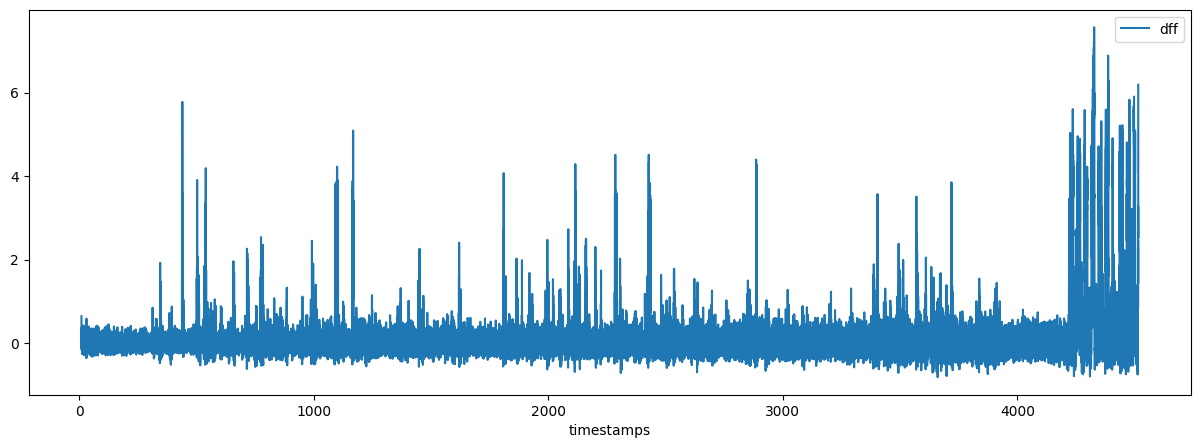

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
single_cell_timeseries.plot(
    x = 'timestamps',
    y = 'dff',
    ax = ax
)
fig.show()

# Load stimulus data into memory
The stimulus table is shared across all experiments (imaging planes) in a session. We can therefore use the stimulus table for just one experiment.

We are going to drop the `image_set` column because it is not informative for our purposes. We can then view the first 10 rows of the stimulus table.

In [ ]:
stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations
stimulus_table.head(10)

duration  end_frame  flashes_since_change  \
stimulus_presentations_id                                              
0                           0.25023    18002.0                   0.0   
1                           0.25000        NaN                   0.0   
2                           0.25021    18092.0                   1.0   
3                           0.25019    18137.0                   2.0   
4                           0.25020    18182.0                   0.0   
5                           0.25019    18227.0                   1.0   
6                           0.25013    18272.0                   2.0   
7                           0.25020    18317.0                   3.0   
8                           0.25019    18362.0                   4.0   
9                           0.25021    18407.0                   5.0   

                           image_index image_name  is_change  omitted  \
stimulus_presentations_id                                               
0                                    0      im065      False    False   
1                                    8    omitted      False     True   
2                                    0      im065      False    False   
3                                    0      im065      False    False   
4                                    3      im061       True    False   
5                                    3      im061      False    False   
6                                    3      im061      False    False   
7                                    3      im061      False    False   
8                                    3      im061      False    False   
9                                    3      im061      False    False   

                           start_frame  start_time   end_time  
stimulus_presentations_id                                      
0                                17987   309.65357  309.90380  
1                                18031   310.38755  310.63755  
2                                18077   311.15483  311.40504  
3                                18122   311.90545  312.15564  
4                                18167   312.65605  312.90625  
5                                18212   313.40666  313.65685  
6                                18257   314.15735  314.40748  
7                                18302   314.90789  315.15809  
8                                18347   315.65850  315.90869  
9                                18392   316.40910  316.65931

## View the `stimulus_templates` attribute
Note that the `unwarped` column contains the image before the application of a spherical warp. All of the pixels labeled 'NaN' will be off-screen (not visible to the mouse) after the warp is applied.

All experiments in a given session will share the same `stimulus_templates`

In [ ]:
### View images presented
#stimulus_presentations = experiment_dataset.stimulus_presentations
#stimulus_presentations.head()

#unique_stimuli = [stimulus for stimulus in stimulus_presentations['image_name'].unique() if stimulus != 'omitted']
#colormap = {image_name: sns.color_palette()[image_number] for image_number, image_name in enumerate(np.sort(unique_stimuli))}
#colormap['omitted'] = np.nan # assign gray to omitted
#colormap

In [ ]:
experiment = experiments[ophys_experiment_ids[0]]
experiment.stimulus_templates

unwarped  \
image_name                                                      
im065       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im077       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im066       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im061       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im063       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im062       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im085       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im069       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   

                                                       warped  
image_name                                                     
im065       [[198, 197, 201, 207, 207, 202, 198, 201, 207,...  
im077       [[129, 135, 140, 142, 140, 135, 129, 124, 117,...  
im066       [[83, 85, 82, 78, 78, 81, 84, 84, 82, 82, 84, ...  
im061       [[125, 126, 126, 126, 125, 125, 125, 125, 125,...  
im063       [[105, 108, 107, 101, 97, 96, 98, 101, 103, 10...  
im062       [[103, 103, 103, 105, 112, 125, 145, 172, 204,...  
im085       [[54, 56, 50, 45, 45, 51, 56, 55, 51, 48, 49, ...  
im069       [[251, 248, 255, 255, 255, 254, 246, 248, 255,...

## View the unwarped images

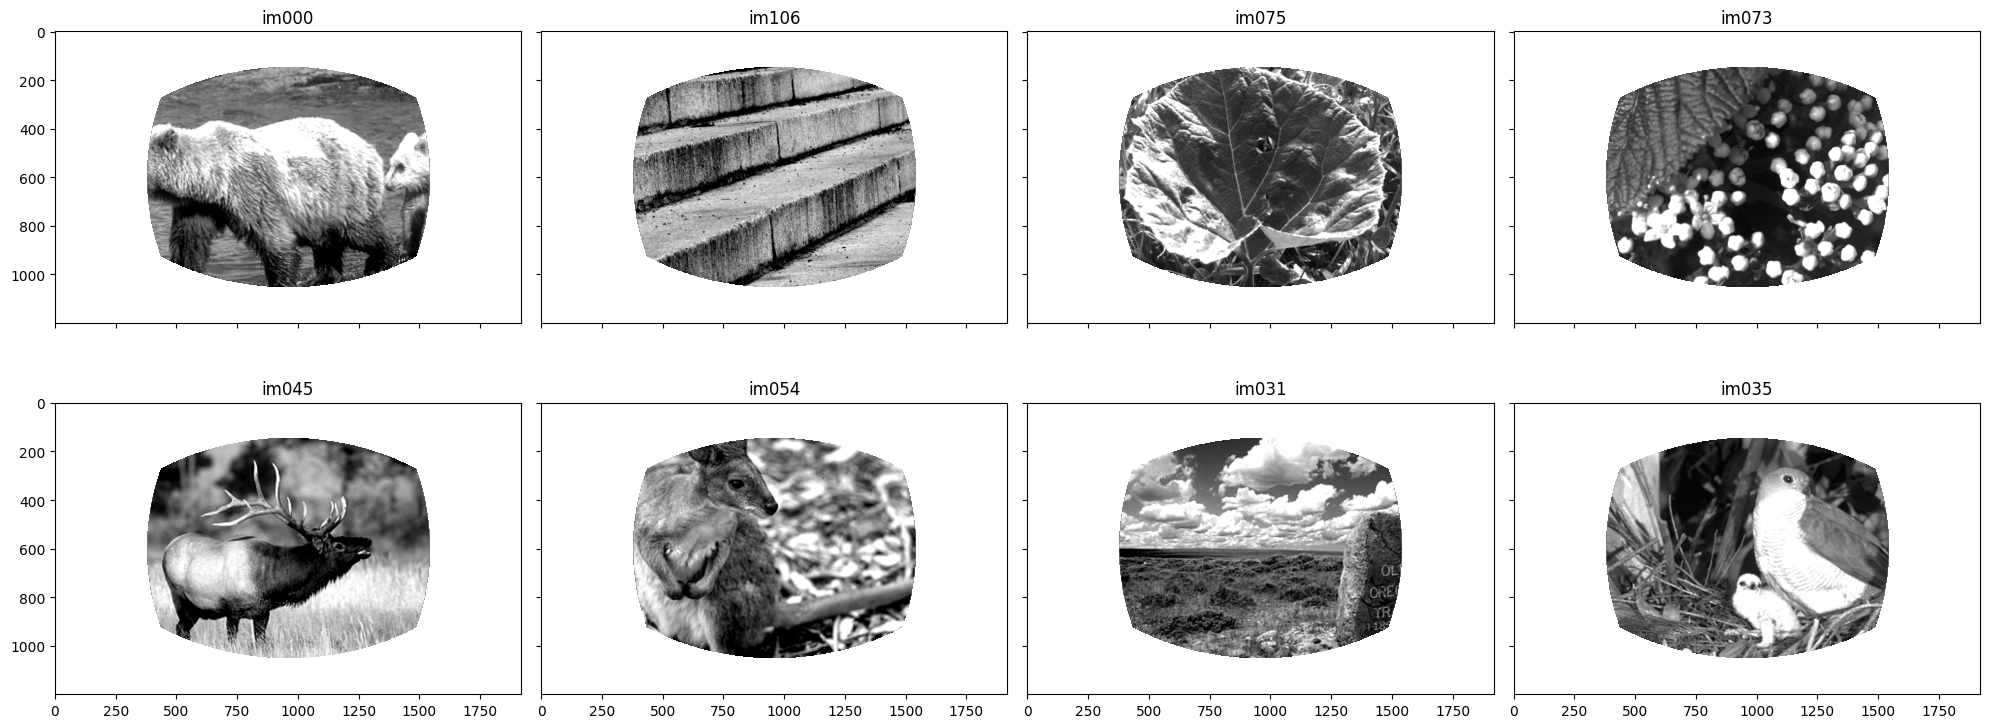

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
for ii, image_name in enumerate(experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(experiment.stimulus_templates.loc[image_name]['unwarped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()
fig.show()

## View the warped images
This represents what was actually on the screen during the session

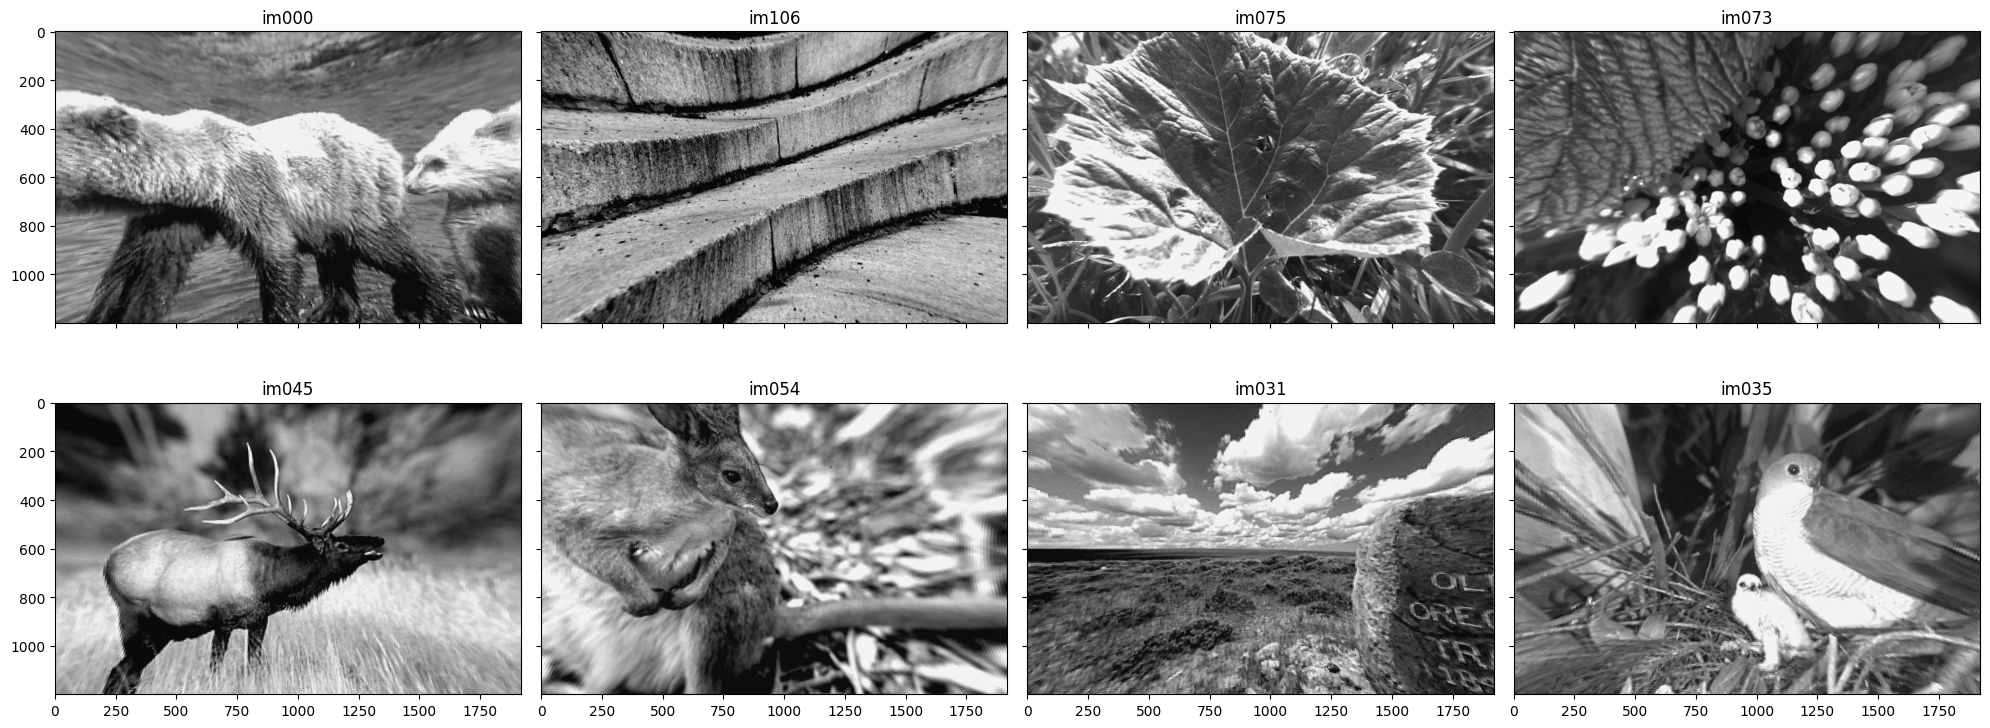

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
for ii, image_name in enumerate(experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(experiment.stimulus_templates.loc[image_name]['warped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()
fig.show()

## Describe stimulus omissions
An important feature of the task is that stimuli are shown at a very regular cadence (250 ms on, 500 ms off), but stimuli are randomly omitted with a probability of ~5%. These unexpected and random stimulus omissions could be perceived as an expectation violation by the mouse.

Omitted stimuli are denoted in the `stimulus_table` by the `omitted` column. `True` means that the stimulus that would have been shown at that time was actually omitted (and was replaced by an extended gray screen between stimuli).

We can look at the first 10 examples of omitted stimuli as follows. Note that each 'omitted' stimulus still has a 'start_time' and a 'stop_time' associated with it. This actually represents the time that a stimulus would have been shown, had it not been omitted.

Stimulus omissions are also indicated in the `image_name` column by the string `omitted`

In [ ]:
stimulus_table.query('omitted').head(10)

duration  end_frame  flashes_since_change  \
stimulus_presentations_id                                              
16                             0.25        NaN                  15.0   
52                             0.25        NaN                   3.0   
83                             0.25        NaN                  19.0   
107                            0.25        NaN                   2.0   
111                            0.25        NaN                   5.0   
182                            0.25        NaN                   4.0   
235                            0.25        NaN                   9.0   
243                            0.25        NaN                  16.0   
250                            0.25        NaN                  22.0   
281                            0.25        NaN                   5.0   

                           image_index image_name  is_change  omitted  \
stimulus_presentations_id                                               
16                                   8    omitted      False     True   
52                                   8    omitted      False     True   
83                                   8    omitted      False     True   
107                                  8    omitted      False     True   
111                                  8    omitted      False     True   
182                                  8    omitted      False     True   
235                                  8    omitted      False     True   
243                                  8    omitted      False     True   
250                                  8    omitted      False     True   
281                                  8    omitted      False     True   

                           start_frame  start_time   end_time  
stimulus_presentations_id                                      
16                               18705   321.55213  321.80213  
52                               20325   348.57421  348.82421  
83                               21719   371.82656  372.07656  
107                              22799   389.84128  390.09128  
111                              22979   392.84374  393.09374  
182                              26175   446.15397  446.40397  
235                              28560   485.93648  486.18648  
243                              28920   491.94138  492.19138  
250                              29235   497.19568  497.44568  
281                              30631   520.48137  520.73137

# Create an event triggered response dataframe relative to omissions
If we want to see how a given cell responds when regularly flashed stimuli are omitted, we can calculate the response around each of the stimulus omissions. The `brain_observatory_utilities` package has a convenience function to do this, in the module we imported as `utilities`. We give the function:
* a dataframe of interest (containing activity from one cell)
* the t and y values of interest
* the event times
* how much time before and after each event we are interested in
* the desired sampling rate of the output - this is the rate onto which the response will be interpolated

The function will return a new dataframe with the response for the given cell, aligned to each of the events.

In [ ]:
cell_id = cell_ids[11]
etr = utilities.event_triggered_response(
    data=neural_data.query('cell_specimen_id == @cell_id'),
    t='timestamps',
    y='dff',
    event_times=stimulus_table.query('omitted')['start_time'],
    t_before=3,
    t_after=3,
    output_sampling_rate=50,
)
etr

time       dff  event_number  stimulus_presentations_id  event_time
0     -3.00 -0.111926             0                         16   321.55213
1     -2.98 -0.111926             0                         16   321.55213
2     -2.96 -0.111926             0                         16   321.55213
3     -2.94 -0.074421             0                         16   321.55213
4     -2.92 -0.035434             0                         16   321.55213
...     ...       ...           ...                        ...         ...
52971  2.92 -0.148875           175                       4798  3911.60124
52972  2.94 -0.148875           175                       4798  3911.60124
52973  2.96 -0.148875           175                       4798  3911.60124
52974  2.98 -0.148875           175                       4798  3911.60124
52975  3.00 -0.148875           175                       4798  3911.60124

[52976 rows x 5 columns]

We can see that the output has colums for
* `time` - this is our new timebase relative to the events. In this case, it ranges from -3 to 3
* `dff` - this is the deltaF/F value surrounding each event, interpolated onto the new timebase. If, when calling the `event_triggered_response` function we had passed `y = 'events'`, this column would be events instead of dff.
* `event_number` - this is an integer representing the count of each event. In this example, there were 185 omissions, so they are numbered from 0 to 184
* `event_time` - this is the time of each event



The docstring for the `event_triggered_response` function can be viewed as follows:

In [ ]:
help(utilities.event_triggered_response)

Help on function event_triggered_response in module brain_observatory_utilities.utilities.general_utilities:

event_triggered_response(data, t, y, event_times, t_start=None, t_end=None, t_before=None, t_after=None, output_sampling_rate=None, include_endpoint=True, output_format='tidy', interpolate=True)
    Slices a timeseries relative to a given set of event times
    to build an event-triggered response.
    
    For example, If we have data such as a measurement of neural activity
    over time and specific events in time that we want to align
    the neural activity to, this function will extract segments of the neural
    timeseries in a specified time window around each event.
    
    The times of the events need not align with the measured
    times of the neural data.
    Relative times will be calculated by linear interpolation.
    
    Parameters:
    -----------
    data: Pandas.DataFrame
        Input dataframe in tidy format
        Each row should be one observation
   

## Plot an event triggered response

The output format of the `event_triggered_response` function is designed to plug directly into Seaborn's `lineplot` plotting function. We can then view the mean response to omitted stimuli with 95% confidence intervals very easily:

<Axes: xlabel='time', ylabel='dff'>

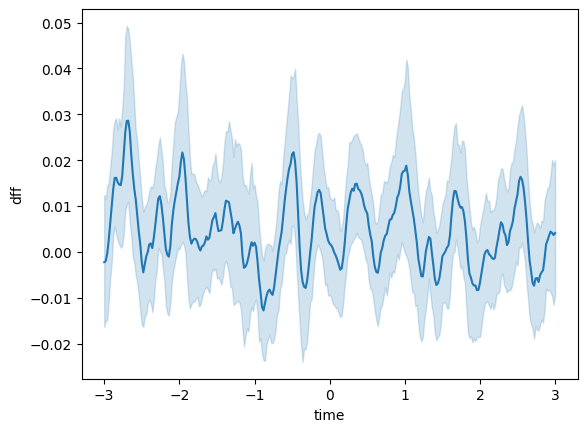

In [ ]:
sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
)

Note that the regular, image-driven responses with a 750 ms inter-stimulus interval are visible everywhere except at t=0, which is when the unexpectedly omitted stimulus occured.

### Make a function to plot an event triggered average in one line

If we make a wrapper function that combines the process of calculating and plotting the event triggered response, it can be called in a single line below. By having `event_query` input variable, we can use this function to plot responses to any event of interest (omisisons, changes, hits/misses, specific images, etc)

In [ ]:
def make_event_triggered_plot(df, x, y, event_query, ax, t_before=3, t_after=3):
    etr = utilities.event_triggered_response(
      data=df,
      t='timestamps',
      y=y,
      event_times=stimulus_table.query(event_query)['start_time'],
      t_before=t_before,
      t_after=t_before,
      output_sampling_rate=50,
      )
    sns.lineplot(
      data=etr,
      x=x,
      y=y,
      n_boot=500,
      ax=ax
      )

Now plot the omission triggered response for the same cell using filtered events (these events extracted from the deltaF/F timeseries using an event extraction algorithm, then smoothed with a half-gaussian kernel) instead of dff.

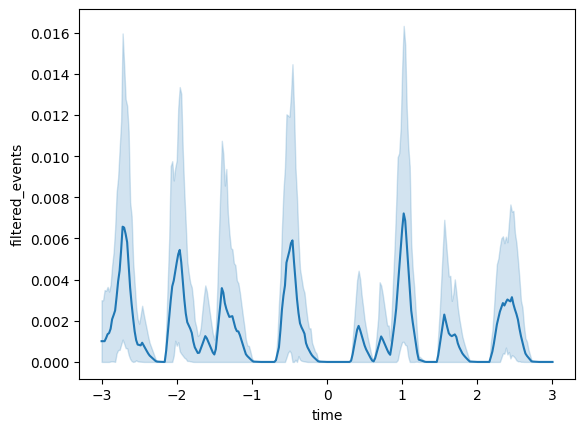

In [ ]:
cell_id = cell_ids[11]
fig, ax = plt.subplots()
make_event_triggered_plot(
    df=neural_data.query('cell_specimen_id == @cell_id'),
    x='time',
    y='filtered_events',
    event_query='omitted',
    ax=ax
)
fig.show()

## Plot the responses for 10 sample cells
We can then iterate over 10 randomly chosen cells and plot their activity during omissions.

100%|██████████| 10/10 [01:14<00:00,  7.42s/it]


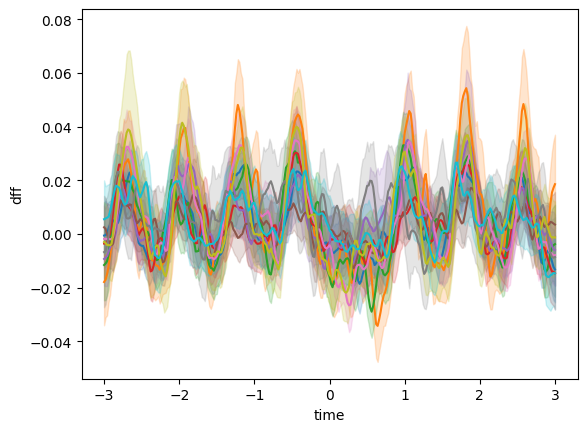

In [ ]:
np.random.seed(0)
fig, ax = plt.subplots()
for cell_id in tqdm(np.random.choice(cell_ids, size=10, replace=False)):
    make_event_triggered_plot(
      df=neural_data.query('cell_specimen_id == @cell_id'),
      x='time',
      y='dff',
      event_query='omitted',
      ax=ax
      )
fig.show()

Interestingly, not all SST cells in this session do the same thing!

## Calculate the mean response for each of the individual imaging planes in this experiment
By iterating over experiment IDs, we can also calculate the mean response for each of the 6 imaging planes. Do Sst cells in different visual areas respond to omissions in a distinct way?

We will first use a Pandas `groupby` and `mean` operations to get the mean timeseries for each cell in that imaging plane:

In [ ]:
mean_dff_by_experiment = (
    neural_data
    .groupby(['ophys_experiment_id','timestamps'])['dff']
    .mean()
    .reset_index()
    )

In [ ]:
mean_dff_by_experiment.head()

ophys_experiment_id  timestamps       dff
0            953659743     9.60844  0.796910
1            953659743     9.70165  0.432817
2            953659743     9.79486  0.427786
3            953659743     9.88807  0.568921
4            953659743     9.98128  0.390961

We can then iterate over our 6 experiment IDs and use our `make_event_triggered_plot` wrapper function to calculate and plot the omission triggered response for that imaging plane:

100%|██████████| 8/8 [01:03<00:00,  7.93s/it]


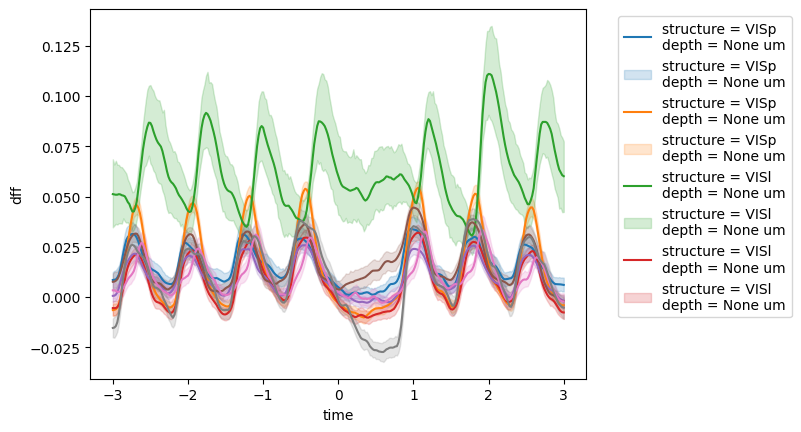

In [ ]:
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

# iterate over every `ophys_experiment_id`
for ophys_experiment_id in tqdm(ophys_experiment_ids):
    make_event_triggered_plot(
      df=mean_dff_by_experiment.query('ophys_experiment_id == @ophys_experiment_id'),
      x='time',
      y='dff',
      event_query='omitted',
      ax=ax
      )

    # get some metadata to add to the legend
    this_exp = neural_data.query('ophys_experiment_id == @ophys_experiment_id')
    structure = this_exp['targeted_structure'].iloc[0]
    depth = this_exp['imaging_depth'].iloc[0]
    # append a string to our list of legend text
    legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))

# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1))
fig.show()

There are clearly some large differences in the way that Sst cells respond to these unexpected stimulus omissions by area.

This example could be extended to include cells from the other two cre-lines in the dataset: The VIP-Cre line which labels VIP+ inhibitory interneurons and the Slc17a7 line, which is a pan-excitatory line.

In [ ]:
session_table['cre_line'].unique()

array(['Sst-IRES-Cre', 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre'], dtype=object)

In addition, responses to different stimuli could be explored, along with responses relative to other behavioral measures, such as licking.

For a full description of the dataset and all available data streams, see the Visual Behavior Project Description at:
https://portal.brain-map.org/explore/circuits/visual-behavior-2p

# Set up data for scikit learn
What if we wanted to use scikit-learn for a decoding or clustering analysis? We'd need to get the data into a standard format for scikit learn, which is often a feature matrix (`X`) and a vector of labels (`y`).

Instead of just omissions, let's now look at the responses to each of the stimuli in this session, which consists of 8 unique images, plus the omitted stimuli (which we characterize as a unique stimulus type). First, we will calculate an event triggered response to each stimulus start time in the stimulus table.

In [ ]:
full_etr_l = []
# iterate over each unique cell
for cell_specimen_id in tqdm(neural_data['cell_specimen_id'].unique()):
  # calculate the event triggered response for this cell to every stimulus
  full_etr_this_cell = utilities.event_triggered_response(
      neural_data.query('cell_specimen_id == @cell_specimen_id'),
      t='timestamps',
      y='dff',
      event_times=stimulus_table['start_time'],
      t_before=0,
      t_after=0.75,
      output_sampling_rate=30
  )
  # add a column identifying the cell_specimen_id
  full_etr_this_cell['cell_specimen_id'] = cell_specimen_id
  # append to our list
  full_etr_l.append(full_etr_this_cell)

# concatenate our list of dataframes into a single dataframe
full_etr = pd.concat(full_etr_l)

# cast these numeric columns to int and float, respectively
full_etr['event_number'] = full_etr['event_number'].astype(int)
full_etr['event_time'] = full_etr['event_number'].astype(float)

# rename 'event_number' as
# full_etr.rename(columns={'event_number': 'stimulus_presentations_id'}, inplace=True)

100%|██████████| 60/60 [02:31<00:00,  2.53s/it]


One way to construct a feature matrix might be to build it such that dimensions are `trials x cells`. Thus:

* Each row would be one trial, where a trial is defined as a unique image presentation
* Each column would represent the average response of a given cell on that image presentation.

To do so, let's construct another intermediate dataframe called `average_responses` that contains the average response of each cell (in the 750 ms window we've selected above) to each image presentation. We'll do this using a Pandas groupby to group by `cell_specimen_id` and `stimulus_presentations_id` (aka trial).

We're also going to merge in our stimulus metadata.

In [ ]:
full_etr['event_number'] = full_etr['event_number'].astype(int)
full_etr['event_time'] = full_etr['event_number'].astype(float)

In [ ]:
average_responses = full_etr.groupby(['cell_specimen_id', 'stimulus_presentations_id'])[['dff']].mean().reset_index().merge(
    stimulus_table,
    on='stimulus_presentations_id',
    how='left'
)
average_responses

cell_specimen_id  stimulus_presentations_id       dff  duration  \
0             1086606974                          0  0.126830   0.25023   
1             1086606974                          1 -0.003338   0.25000   
2             1086606974                          2 -0.247283   0.25021   
3             1086606974                          3 -0.420208   0.25019   
4             1086606974                          4  2.303460   0.25020   
...                  ...                        ...       ...       ...   
288175        1086624821                       4798  0.128748   0.25022   
288176        1086624821                       4799 -0.031925   0.25021   
288177        1086624821                       4800 -0.072003   0.25000   
288178        1086624821                       4801  0.067383   0.25022   
288179        1086624821                       4802  0.066287   0.25023   

        end_frame  flashes_since_change  image_index image_name  is_change  \
0         18002.0                   0.0            0      im065      False   
1             NaN                   0.0            8    omitted      False   
2         18092.0                   1.0            0      im065      False   
3         18137.0                   2.0            0      im065      False   
4         18182.0                   0.0            3      im061       True   
...           ...                   ...          ...        ...        ...   
288175   233945.0                   1.0            2      im066      False   
288176   233990.0                   2.0            2      im066      False   
288177        NaN                   2.0            8    omitted      False   
288178   234080.0                   3.0            2      im066      False   
288179   234125.0                   4.0            2      im066      False   

        omitted  start_frame  start_time    end_time  
0         False        17987   309.65357   309.90380  
1          True        18031   310.38755   310.63755  
2         False        18077   311.15483   311.40504  
3         False        18122   311.90545   312.15564  
4         False        18167   312.65605   312.90625  
...         ...          ...         ...         ...  
288175    False       233930  3911.64698  3911.89720  
288176    False       233975  3912.39761  3912.64782  
288177     True       234019  3913.13153  3913.38153  
288178    False       234065  3913.89882  3914.14904  
288179    False       234110  3914.64942  3914.89965  

[288180 rows x 13 columns]

Now we can construct a dataframe called `features_and_labels` that will contain one row per trial, one column per cell, plus columns with the image_index and image_name

In [ ]:
features_and_labels = average_responses.pivot(
    index='stimulus_presentations_id',
    columns='cell_specimen_id',
    values='dff'
).merge(
    stimulus_table[['image_index','image_name']],
    on='stimulus_presentations_id',
    how='left'
)
features_and_labels.sample(10)

1086606974  1086607071  1086607143  1086607195  \
stimulus_presentations_id                                                   
1621                        -0.146296    0.139161    0.007278    0.146714   
4098                        -0.011052   -0.123044   -0.005508   -0.033330   
3135                        -0.151481   -0.098068   -0.026276   -0.080912   
1861                         0.054363   -0.003811    0.002752   -0.018509   
1571                        -0.020123    0.076532   -0.008103   -0.085742   
3055                         0.276963   -0.015029   -0.049631    0.157241   
2841                         0.187417    0.019824    0.600690    0.042906   
4665                        -0.456149    0.010181   -0.013342   -0.111826   
113                          0.089716    0.043501    0.014091    0.464805   
3472                         2.576395    0.053699    0.045642    0.030420   

                           1086607340  1086607431  1086607562  1086607713  \
stimulus_presentations_id                                                   
1621                         0.011249    0.011370   -0.007103    0.063285   
4098                         0.096516   -0.105191    0.033485   -0.094419   
3135                        -0.011834    0.051368    0.040320    0.058458   
1861                        -0.048386    0.027614   -0.012691   -0.083002   
1571                        -0.033353   -0.034143    0.015507   -0.156166   
3055                        -0.016724   -0.002019    0.032873    0.089271   
2841                         0.095201    0.036494    0.055403   -0.003722   
4665                        -0.047386    0.064346   -0.033478   -0.072821   
113                          0.050808    0.080381    0.014827    0.131803   
3472                        -0.040759    0.077762    0.039162    0.095000   

                           1086607768  1086607814  1086607903  1086607998  \
stimulus_presentations_id                                                   
1621                         0.199458    0.028751   -0.005205    0.777781   
4098                        -0.076858   -0.035463    0.931862    0.493863   
3135                         0.096552    0.008416    0.005886   -0.080494   
1861                        -0.078601   -0.043948    0.032633   -0.605340   
1571                         0.125136    0.009150    0.015765   -0.007919   
3055                         0.031265   -0.020591    0.095166   -0.302571   
2841                        -0.099413   -0.041720    0.306880    0.435455   
4665                         0.026097    0.015701    0.018122   -0.093917   
113                          0.013258    0.048960   -0.030375    1.013996   
3472                        -0.095474    0.043678   -0.054527    0.080296   

                           1086608075  1086608138  1086608195  1086608294  \
stimulus_presentations_id                                                   
1621                        -0.011310    0.012952    0.005722    0.005522   
4098                         0.013703    0.027661    0.120081   -0.014489   
3135                        -0.013033    0.041110    0.046591   -0.028163   
1861                         0.014713   -0.044672    0.015944    0.016181   
1571                         0.056746    0.055529   -0.011815    0.010264   
3055                         0.004757   -0.046240    0.084816    0.020975   
2841                        -0.055748   -0.016391   -0.006031    0.014439   
4665                        -0.040301   -0.005019   -0.023763   -0.034045   
113                          0.009317   -0.016533    0.958347    0.000350   
3472                        -0.027709   -0.022176    0.021967    0.043232   

                           1086608379  1086608491  1086608630  1086608811  \
stimulus_presentations_id                                                   
1621                        -0.005463    0.065344    1.200333    0.079157   
4098                        -0.004348    0.219206    2.873154    0.525440   
3135               

The X matrix can be extracted by getting the columns associated with the cell_specimen_ids

In [ ]:
X = features_and_labels[cell_ids]
X.sample(10)

1086622595  1086622778  1086624500  1086620813  \
stimulus_presentations_id                                                   
3039                        -0.077667   -0.072424   -0.047492    0.035199   
4075                        -0.010170    0.042388   -0.027926   -0.035136   
1850                        -0.001996    0.009004   -0.006969    0.019714   
2727                        -0.019808    0.015981   -0.000279   -0.078756   
1145                        -0.048665    0.060038   -0.003062    0.752320   
2452                        -0.000351    0.002453    0.006137    0.034222   
4169                         0.017304    0.047739    0.034354   -0.058154   
2458                        -0.014998   -0.038751    0.012975   -0.103623   
3991                        -0.025221    0.094836   -0.006205    0.086226   
2724                        -0.072921    0.026111   -0.016463   -0.023165   

                           1086620446  1086621290  1086621629  1086621968  \
stimulus_presentations_id                                                   
3039                         0.028827   -0.029836    0.044697   -0.093978   
4075                         0.005047   -0.048217    0.059431   -0.005226   
1850                         0.017995   -0.061710    0.075135   -0.008788   
2727                         0.030248   -0.037275   -0.018863   -0.020399   
1145                        -0.040674   -0.014168   -0.035083    0.321697   
2452                        -0.012977    0.177705    0.151610    0.035274   
4169                        -0.010720   -0.028382    0.020991    0.055897   
2458                        -0.010046   -0.107837   -0.297743   -0.056192   
3991                         0.011041   -0.050719    0.095450    0.195990   
2724                         0.019349   -0.069816   -0.001170   -0.017578   

                           1086622408  1086621068  1086624821  1086622997  \
stimulus_presentations_id                                                   
3039                        -0.010701   -0.120189    0.031920    0.002063   
4075                        -0.171452    0.057892   -0.051690    0.073769   
1850                         0.120891    0.042718   -0.010814    0.061979   
2727                        -0.352091    0.043118   -0.053825   -0.006773   
1145                         0.026579    0.029241    0.016137    0.085655   
2452                         0.498298    0.034943    0.096456    0.152964   
4169                         3.287479    0.019716    0.023451    0.668084   
2458                         0.053635   -0.079464   -0.079215   -0.046244   
3991                        -0.495183    0.001066    0.060952   -0.039998   
2724                         1.425565   -0.108803   -0.013107    0.088318   

                           1086623189  1086619317  1086619511  1086619787  \
stimulus_presentations_id                                                   
3039                         0.104924   -0.069417   -0.277911    0.904428   
4075                         0.081411   -0.075754    0.936854    2.953059   
1850                         0.009059    0.091214    5.409705    0.051307   
2727                        -0.086061   -0.046896   -0.227896   -0.125313   
1145                        -0.004966    0.006028    0.928340    0.131733   
2452                         0.337708    0.242597    0.241853    0.012324   
4169                         0.003349    0.224825    0.832458   10.113651   
2458                        -0.007887   -0.061146   -1.118967   -0.089767   
3991                        -0.016187    0.039557   -0.161958   -0.079337   
2724                         0.587257    0.073173   -0.065285    0.000979   

                           1086620671  1086619928  1086620900  1086622864  \
stimulus_presentations_id                                                   
3039                        -0.028238   -0.166664   -0.048400    0.028558   
4075                         0.097181    0.117468    0.015639    0.067620   
1850               

And `y` is just the `image_name` column (it could also be the `image_index` column if you want a numeric value instead of a string to represent the image identity)

In [ ]:
y = features_and_labels['image_name']
y.sample(10)

stimulus_presentations_id
3536    im077
1555    im085
34      im066
489     im069
4205    im069
3596    im065
1442    im077
1385    im077
3928    im065
4515    im061
Name: image_name, dtype: object

## Dimensionality reduction
Now we can use t-SNE, which will project our 53-dimensional feature space (53 neurons in the session) into two dimensions.

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(X.values)

And visualize the results, with colors representing each unique stimulus.

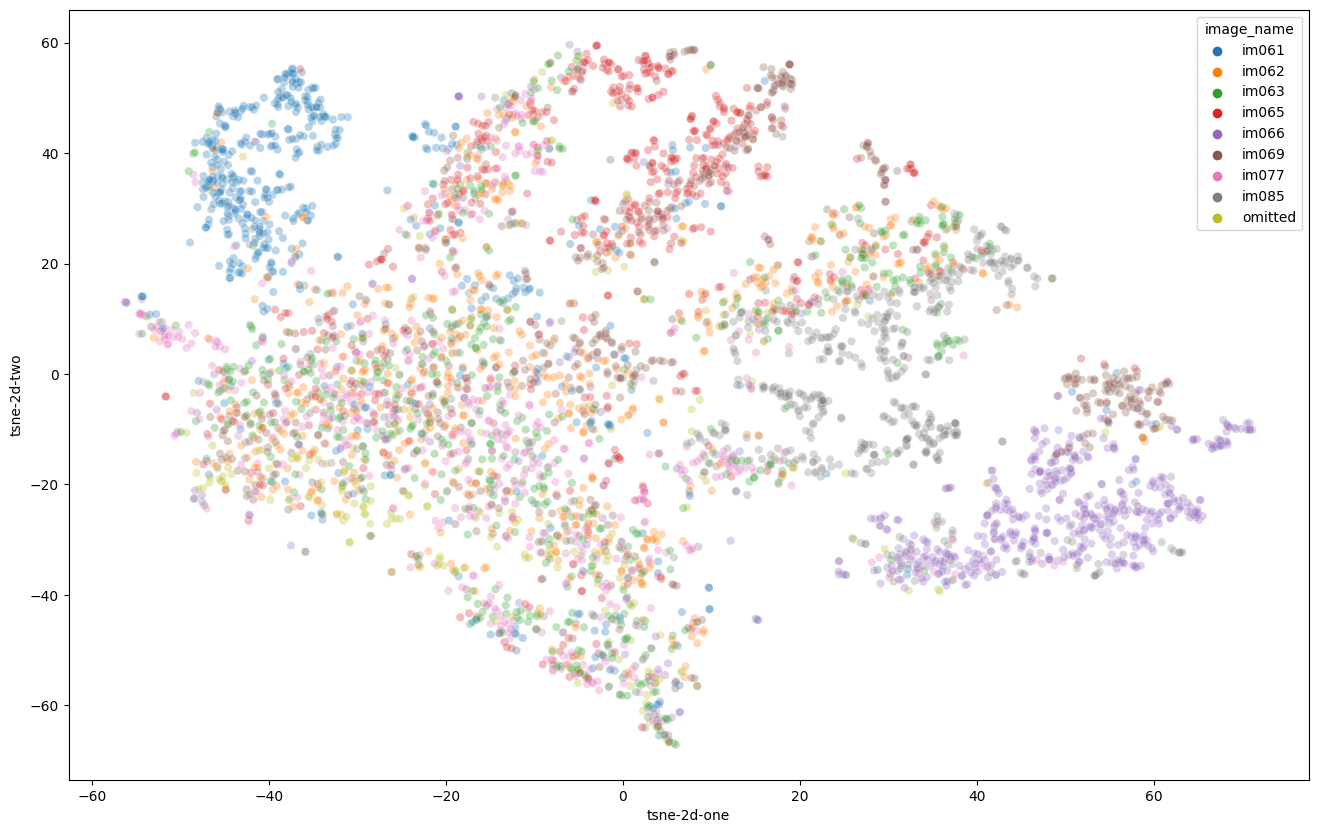

In [ ]:
features_and_labels['tsne-2d-one'] = X_embedded[:, 0]
features_and_labels['tsne-2d-two'] = X_embedded[:, 1]
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(
    data=features_and_labels,
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="image_name",
    hue_order=np.sort(features_and_labels['image_name'].unique()),
    palette=sns.color_palette()[:9],
    legend="full",
    alpha=0.3
)

This demonstrates that the time-averaged population responses to at least some of the stimuli seem to fall into distinct clusters in our 53-dimensional space, while others appear more overlapped. This implies that a decoding analysis might be more successful at decoding some stimuli than others.

## Train a simple decoder
We can use an SVM decoder from scikit learn to ask how well we can decode image identity from the feature matrix we have constructed.

Split our data into train and test sets, instantiate the model, then fit.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = svm.SVC(probability=True)
model.fit(X_train, y_train)

SVC(probability=True)

Use the model to make predictions on the held-out test set

In [ ]:
y_pred = model.predict(X_test)

Evaluate the accuracy

In [ ]:
accuracy_score(y_test, y_pred)

0.6006309148264984

Evaluate the confusion matrix

In [ ]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['predicted_{}'.format(im) for im in model.classes_],
    index=['actual_{}'.format(im) for im in model.classes_]
)

predicted_im061  predicted_im062  predicted_im063  \
actual_im061                127               29                5   
actual_im062                  6              129                4   
actual_im063                  2               55               56   
actual_im065                  0               19                5   
actual_im066                  1                6                4   
actual_im069                  1               54                2   
actual_im077                  2               36               26   
actual_im085                  0               11                3   
actual_omitted                1               16                3   

                predicted_im065  predicted_im066  predicted_im069  \
actual_im061                  8                1                4   
actual_im062                  3                0               10   
actual_im063                  2                2                2   
actual_im065                 95                0               13   
actual_im066                  1              162                8   
actual_im069                 33                7               85   
actual_im077                  4                2                0   
actual_im085                  1                6                0   
actual_omitted                2                3                4   

                predicted_im077  predicted_im085  predicted_omitted  
actual_im061                 16                0                  2  
actual_im062                 21                6                  2  
actual_im063                 57               15                  7  
actual_im065                 12                9                  2  
actual_im066                 11                0                  1  
actual_im069                 21                2                  2  
actual_im077                128                5                  1  
actual_im085                 15              148                  0  
actual_omitted               16                3                 22

This tells us that the model can decode some stimuli well (im035, im075 and im106, for example), while it struggles more with others (im000 and omissions, for example). Do the stimuli that the decoder succeeds in classifying align with those that cluster cleanly in t-SNE space?

### Follow up exercise

Can you create event triggered averages and perform decoding using other events of interest, such as licks or rewards?

In [ ]:
# Lick and reward data are available for each experiment
licks = experiments[ophys_experiment_id].licks
licks.head()

In [ ]:
rewards = experiments[ophys_experiment_id].rewards
rewards.head()

To see the full list of all attributes available for each experiment via the AllenSDK, uncomment the cell below and run it

In [ ]:
# help(experiments[ophys_experiment_id])

In [ ]:
### EXTRACTING SESSION DATA THAT WE WANT